## Import Libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline
import seaborn as sns
sns.set(context='paper', style='darkgrid', 
        rc={'figure.facecolor':'white'}, font_scale=1.2)
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# remove scientific notation and restrictions on df rows/columns display
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('display.max_colwidth', 150)

## Import Data

In [20]:
# load merged dataframe
file_merged = '../datasets/merged.csv'
merged = pd.read_csv(file_merged, dtype={'customer_zip_code_prefix': str, 'seller_zip_code_prefix': str})
merged.head(3)



,order_id,order_status,customer_unique_id,customer_zip_code_prefix,customer_state,product_id,seller_id,price,freight_value,product_category,product_weight,product_volume,seller_zip_code_prefix,seller_state,review_score,est_delivery_days,act_delivery_days,days_variance,product_category_groups,bad_review,late_delivery,country,seller_bad_cnt,seller_order_cnt,seller_bad_pct,product_bad_cnt,product_order_cnt,product_bad_pct,order_item_cnt,order_seller_cnt,order_value,order_freight,order_avg_price,order_freight_ratio,cust_zip_lat_long,sell_zip_lat_long,delivery_km
0,c0412e955e8866bd36d56c196d1c9d82,delivered,7c337b5cbae22f0ecb7b756873e487b9,13070,SP,ff50a7795bf14586aeb06610fae49095,4a3ca9315b744ce9f8e9374361493884,119.90,12.34,bed_bath_table,"2,100.00","24,000.00",14940,SP,5.00,19.00,11.00,8.00,Furnitures,0.00,0.00,Brazil,312.00,"1,726.00",0.18,0.00,1.00,0.00,1.00,1.00,119.90,12.34,119.90,0.10,"(-22.8935112964107, -47.0800242164147)","(-21.757690120914923, -48.82976816265947)",220.00
1,f7c82561ae5213f3564251a07c475d1e,delivered,e30e0e57e66477dad963535b38974023,13015,SP,166afe76948e93ed13181b01febfeb25,4a3ca9315b744ce9f8e9374361493884,155.90,12.59,bed_bath_table,"4,200.00","36,040.00",14940,SP,5.00,20.00,10.00,10.00,Furnitures,0.00,0.00,Brazil,312.00,"1,726.00",0.18,0.00,1.00,0.00,1.00,1.00,155.90,12.59,155.90,0.08,"(-22.90479794532287, -47.05693855329215)","(-21.757690120914923, -48.82976816265947)",223.00
2,20f00734b9cedbed78661618c0deb7fd,delivered,b8c783be6cfce8d7d9a4c0883ec5f36c,11701,SP,f1e0c91e748d3ddfb2728c51078c2b08,4a3ca9315b744ce9f8e9374361493884,69.90,12.93,bed_bath_table,200.00,"12,000.00",14940,SP,5.00,19.00,17.00,2.00,Furnitures,0.00,0.00,Brazil,312.00,"1,726.00",0.18,0.00,1.00,0.00,1.00,1.00,69.90,12.93,69.90,0.18,"(-24.00920985345376, -46.41937090980433)","(-21.757690120914923, -48.82976816265947)",352.00


## Data Cleaning

In [ ]:
# check numeric column ranges
merged.describe()

In [83]:
# check value counts by column
col_list = ['review_score']

for col in col_list:
     print(f'\nValue Counts | column = {col}')
     print(merged[col].value_counts(normalize=True, dropna=False))


Value Counts | column = review_score
5.00   0.59
4.00   0.20
1.00   0.10
3.00   0.08
2.00   0.03
NaN    0.00
Name: review_score, dtype: float64


In [ ]:
# check value counts by column
col_list = ['order_id',  'order_status', 'customer_unique_id',  
            'customer_state', 'product_id', 'seller_id', 'price', 
            'freight_value', 'product_category', 'product_weight', 'seller_zip_code_prefix', 'review_score', 'act_delivery_days', 'est_delivery_days', 'days_variance', 'product_category_groups', 'bad_review', 'late_delivery', 'country']      

for col in col_list:
     print(f'\nValue Counts | column = {col}')
     print(merged[col].value_counts(normalize=True, dropna=False))

In [ ]:
# write into merged file 
# merged.to_csv("../datasets/merged.csv", index=False)

### Order Aggregate Measures

In [ ]:
order_cnts = merged.groupby('order_id').agg(order_item_cnt=('product_id', 'count'),
                                            order_seller_cnt=('seller_id', 'nunique'),
                                            order_value=('price', 'sum'),
                                            order_freight=('freight_value', 'sum'),
                                            order_avg_price=('price', 'mean')).reset_index()

merged = pd.merge(left=merged, right=order_cnts, how='inner', 
                  left_on='order_id', right_on='order_id')

merged['order_freight_ratio'] = merged['freight_value'] / merged['order_value']

# check distribution on two dimensions
merged[['order_item_cnt','order_seller_cnt']].apply(pd.Series.value_counts)

### Delivery Distance km

In [ ]:
# load geolocation dataframe
geolocation = '../datasets/olist_geolocation_dataset.csv'
geolocation_df = pd.read_csv(geolocation, 
                             dtype={'geolocation_zip_code_prefix': str})
zip_loc_lookup = (
    geolocation_df
    .groupby('geolocation_zip_code_prefix') 
    .agg(zip_lat=('geolocation_lat', 'median'), 
         zip_long=('geolocation_lng', 'median'))
    .reset_index())

# drop full geolocation frame
del geolocation_df

# create lat-long tuple for distance calcs, drop lat/long
zip_loc_lookup['zip_lat_long'] = tuple(zip(zip_loc_lookup.zip_lat, 
                                           zip_loc_lookup.zip_long))
zip_loc_lookup.drop(columns=['zip_lat', 'zip_long'], inplace=True)
zip_loc_lookup.head()

In [ ]:
# append columns for customer lat-long values
merged = pd.merge(left=merged, right=zip_loc_lookup, how='left', 
                  left_on='customer_zip_code_prefix', 
                  right_on='geolocation_zip_code_prefix')\
                  .rename(columns = {'zip_lat_long': 'cust_zip_lat_long'})

# drop extra zip code field
merged.drop(['geolocation_zip_code_prefix'], axis=1, inplace=True)

# append columns for seller lat-long values
merged = pd.merge(left=merged, right=zip_loc_lookup, how='left', 
                  left_on='seller_zip_code_prefix', 
                  right_on='geolocation_zip_code_prefix')\
                  .rename(columns = {'zip_lat_long': 'sell_zip_lat_long'})


In [ ]:
# # drop extra zip code field
# merged.drop(['geolocation_zip_code_prefix'], axis=1, inplace=True)

# # dropping rows without proper geolocation details
# print(f'{len(merged[(merged.sell_zip_lat_long.isnull()==True) | (merged.cust_zip_lat_long.isnull()==True)])} '
#       f'rows to be dropped without lat-long')
      
# merged.drop(merged[(merged.sell_zip_lat_long.isnull()==True) 
#                    | (merged.cust_zip_lat_long.isnull()==True)].index, 
#                                                         inplace=True)

In [ ]:
# function to calculate haversine distance between lat-long coordinates
def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [ ]:
# create feature of miles from city center of Seattle
# merged['delivery_km'] = merged.apply(lambda row: 
#                                      round(haversine(row['cust_zip_lat_long'], 
#                                                      row['sell_zip_lat_long'])/1000, 0), 
#                                      axis=1).astype('int64')

In [ ]:
# merged.to_csv("../datasets/merged.csv")

In [86]:
def find_outliers(df, std_devs):
    #define a list to accumlate outliers
    """Calculates mean, standard deviation, lower/upper limits and outlier 
    counts and % of total records in dataframe based on desired number 
    of standard deviations.

    Parameters:
    df (pd.DataFrame)): Name of Pandas dataframe
    std_devs (int): Number of standard deviations that define an outlier

    Returns: df_outliers (dict): Dictionary of outlier indicies by column
   """
    df_outliers = {}
    print(f'Outliers at greater than {std_devs} standard deviations')
    print('----------------------------------------------')
    for column in df:
        outliers = []
        df[column].astype(float)
    
        # Set upper and lower limit to 4 standard deviation
        series_std = np.std(df[column])
        series_mean = np.mean(df[column])
        outlier_cut_off = series_std * std_devs
        lower_limit  = series_mean - outlier_cut_off 
        upper_limit = series_mean + outlier_cut_off 

        # Generate outliers
        for index, value in df[column].iteritems():
            if value > upper_limit or value < lower_limit:
                outliers.append({'index': index, 'value': value})

        print(f'{column} | mean {round(series_mean,1)} | std {round(series_std,1)} | ll={round(lower_limit,1)} | '
              f'ul={round(upper_limit,1)} | outliers={len(outliers)} |'
              f'{len(df[column])} outlier % {len(outliers)/len(df[column]):.2%}')
        df_outliers[column]= outliers

        
    return df_outliers


# create log transform columns
log_cols = ['price', 'freight_value', 'product_weight', 'product_volume', 'seller_bad_pct', 'product_bad_pct', 'product_order_cnt', 
            'order_item_cnt', 'order_seller_cnt', 'order_value', 'order_freight', 
            'order_avg_price', 'order_freight_ratio', 'est_delivery_days', 
            'act_delivery_days', 'days_variance', 'delivery_km']

# generate list of outliers on gaussian columns
df_outliers = find_outliers(merged[log_cols], 6)

df_ols = pd.DataFrame.from_dict(df_outliers, orient='index')
df_ols = df_ols.transpose()



# print(df_outliers)

Outliers at greater than 6 standard deviations
----------------------------------------------
price | mean 136.9 | std 197.1 | ll=-1045.7 | ul=1319.4 | outliers=230 |46732 outlier % 0.49%
freight_value | mean 22.8 | std 17.3 | ll=-80.7 | ul=126.3 | outliers=197 |46732 outlier % 0.42%
product_weight | mean 2192.9 | std 3739.7 | ll=-20245.4 | ul=24631.2 | outliers=183 |46732 outlier % 0.39%
product_volume | mean 15248.6 | std 22669.5 | ll=-120768.6 | ul=151265.9 | outliers=167 |46732 outlier % 0.36%
seller_bad_pct | mean 0.1 | std 0.1 | ll=-0.4 | ul=0.6 | outliers=82 |46732 outlier % 0.18%
product_bad_pct | mean 0.1 | std 0.2 | ll=-0.9 | ul=1.1 | outliers=0 |46732 outlier % 0.00%
product_order_cnt | mean 32.3 | std 69.1 | ll=-382.1 | ul=446.6 | outliers=0 |46732 outlier % 0.00%
order_item_cnt | mean 1.0 | std 0.0 | ll=1.0 | ul=1.0 | outliers=0 |46732 outlier % 0.00%
order_seller_cnt | mean 1.0 | std 0.0 | ll=1.0 | ul=1.0 | outliers=0 |46732 outlier % 0.00%
order_value | mean 136.9 | std 

In [ ]:
# df_ols.to_csv("../datasets/outliers_analysis.csv")

In [ ]:
# generate unique list of outlier indicies to drop
outlier_indicies = []
for key, value in df_outliers.items():
    for outlier in value:
        outlier_indicies.append(outlier['index'])
print(f'{len(np.unique(outlier_indicies))} unique outlier indicies')

# create alternate dataframe with no outliers
merged_no_outliers = merged.drop(outlier_indicies)

In [ ]:
# check for collinearity among potential predictors by pairs
df = (corr
     .stack()
     .reset_index()
     .sort_values(0, ascending=False)
)
# zip the default name columns level_0 and level_1
df['pairs'] = list(zip(df.level_0, df.level_1))
# set index to pairs
df.set_index(['pairs'], inplace=True)
# now drop level columns
df.drop(columns=['level_1', 'level_0'], inplace=True)
# rename correlation column rather than 0
df.columns = ['correlation']
# drop duplicates and keep only pair correlations above 0.65
df.drop_duplicates(inplace=True)
df[abs(df.correlation) > .50]


## Outlier Analysis

In [116]:
out_col = ['price', 'freight_value', 'product_weight', 'product_volume', 'review_score', 'seller_bad_pct', 'product_bad_pct', 'product_order_cnt', 'order_item_cnt', 'order_seller_cnt', 'order_value', 'order_freight', 'order_avg_price', 'order_freight_ratio', 'est_delivery_days', 'act_delivery_days', 'days_variance', 'delivery_km']

def find_outliers(df, std_devs):
    #define a list to accumlate outliers
    """Calculates mean, standard deviation, lower/upper limits and outlier 
    counts and % of total records in dataframe based on desired number 
    of standard deviations.

    Parameters:
    df (pd.DataFrame)): Name of Pandas dataframe
    std_devs (int): Number of standard deviations that define an outlier

    Returns: df_outliers (dict): Dictionary of outlier indicies by column
   """
    df_outliers = {}
    print(f'Outliers at greater than {std_devs} standard deviations')
    print('----------------------------------------------')
    for column in df:
        outliers = []
        df[column].astype(float)
    
        # Set upper and lower limit to 4 standard deviation
        series_std = np.std(df[column])
        series_mean = np.mean(df[column])
        outlier_cut_off = series_std * std_devs
        lower_limit  = series_mean - outlier_cut_off 
        upper_limit = series_mean + outlier_cut_off 

        # Generate outliers
        for index, value in df[column].iteritems():
            if value > upper_limit or value < lower_limit:
                outliers.append({'index': index, 'value': value})
            
        print(f'{column} | mean {round(series_mean,1)} | std {round(series_std,1)} | ll={round(lower_limit,1)} | '
              f'ul={round(upper_limit,1)} | outliers={len(outliers)} |'
              f'{len(df[column])} outlier % {len(outliers)/len(df[column]):.2%}')
        df_outliers[column]= outliers
        
    return df_outliers

find_outliers(merged[out_col], 6)


Outliers at greater than 6 standard deviations
----------------------------------------------
price | mean 136.9 | std 197.1 | ll=-1045.7 | ul=1319.4 | outliers=230 |46732 outlier % 0.49%
freight_value | mean 22.8 | std 17.3 | ll=-80.7 | ul=126.3 | outliers=197 |46732 outlier % 0.42%
product_weight | mean 2192.9 | std 3739.7 | ll=-20245.4 | ul=24631.2 | outliers=183 |46732 outlier % 0.39%
product_volume | mean 15248.6 | std 22669.5 | ll=-120768.6 | ul=151265.9 | outliers=167 |46732 outlier % 0.36%
review_score | mean 4.1 | std 1.3 | ll=-3.7 | ul=12.0 | outliers=0 |46732 outlier % 0.00%
seller_bad_pct | mean 0.1 | std 0.1 | ll=-0.4 | ul=0.6 | outliers=82 |46732 outlier % 0.18%
product_bad_pct | mean 0.1 | std 0.2 | ll=-0.9 | ul=1.1 | outliers=0 |46732 outlier % 0.00%
product_order_cnt | mean 32.3 | std 69.1 | ll=-382.1 | ul=446.6 | outliers=0 |46732 outlier % 0.00%
order_item_cnt | mean 1.0 | std 0.0 | ll=1.0 | ul=1.0 | outliers=0 |46732 outlier % 0.00%
order_seller_cnt | mean 1.0 | std

{'price': [{'index': 602, 'value': 2218.0},
  {'index': 832, 'value': 2170.0},
  {'index': 1056, 'value': 1589.0},
  {'index': 1100, 'value': 2062.99},
  {'index': 1114, 'value': 2699.0},
  {'index': 1177, 'value': 2699.0},
  {'index': 1189, 'value': 2299.95},
  {'index': 1209, 'value': 1658.83},
  {'index': 1312, 'value': 1332.5},
  {'index': 1352, 'value': 3124.0},
  {'index': 1604, 'value': 4799.0},
  {'index': 1659, 'value': 2199.0},
  {'index': 1661, 'value': 1350.0},
  {'index': 1855, 'value': 3099.9},
  {'index': 1903, 'value': 1690.0},
  {'index': 1954, 'value': 1608.99},
  {'index': 2213, 'value': 1460.99},
  {'index': 2259, 'value': 1800.0},
  {'index': 2266, 'value': 1699.99},
  {'index': 2364, 'value': 1455.0},
  {'index': 2509, 'value': 2428.0},
  {'index': 2577, 'value': 1999.9},
  {'index': 2655, 'value': 3899.0},
  {'index': 2712, 'value': 1837.9},
  {'index': 3207, 'value': 1610.0},
  {'index': 3545, 'value': 1878.33},
  {'index': 3618, 'value': 1332.5},
  {'index': 36

In [ ]:
outlier_df = pd.DataFrame(find_outliers(merged[out_col], 6))

## Train Test Split

In [117]:
col1 = ['product_bad_pct', 'est_delivery_days', 'act_delivery_days', 'late_delivery', 'seller_bad_pct', 'days_variance']

X_train, X_test, y_train, y_test = train_test_split(merged[col1], merged['bad_review'], test_size=0.20, random_state=0)

# create Logistic Regression classifier object
model_lr = LogisticRegression()

X_test = X_test.fillna(0)
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

model_lr.fit(X_train.values, y_train)
y_pred = model_lr.predict(X_test)


C:\Users\eugen\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\eugen\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## Pearson Correlation

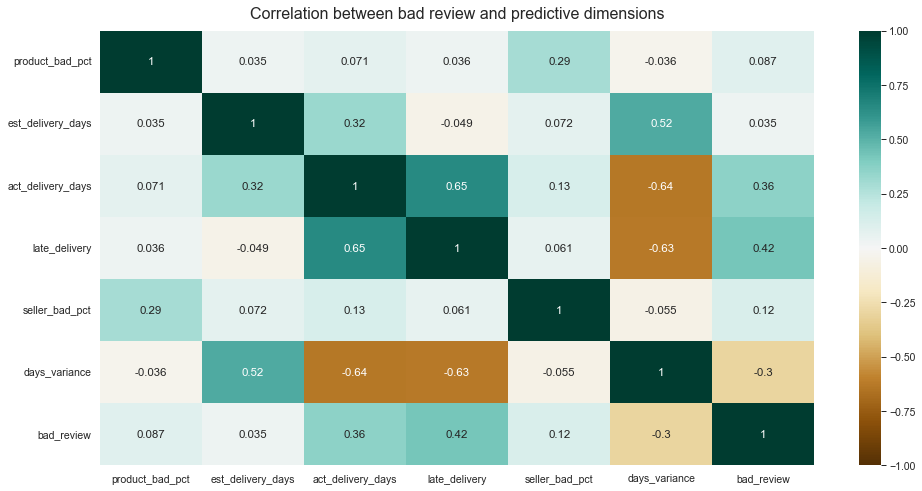

In [106]:
# create column correlation matrix
train_comb = pd.concat([X_train, y_train], axis=1)
corr = train_comb.corr()

plt.figure(figsize=(16, 8))

heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation between bad review and predictive dimensions', fontdict={'fontsize':16}, pad=12);

## Logistic Regression

### Confusion Matrix

Accuracy: 0.8902321600513534
Precision: 0.6805324459234608
Recall: 0.32904263877715206


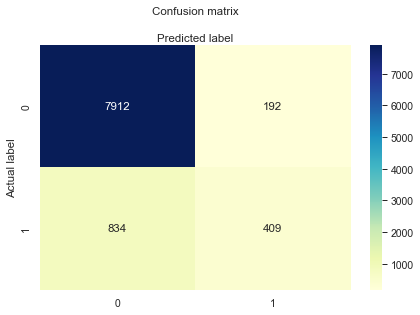

In [79]:

# Create confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

### Roc Curve

0.7270442017251197


C:\Users\eugen\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


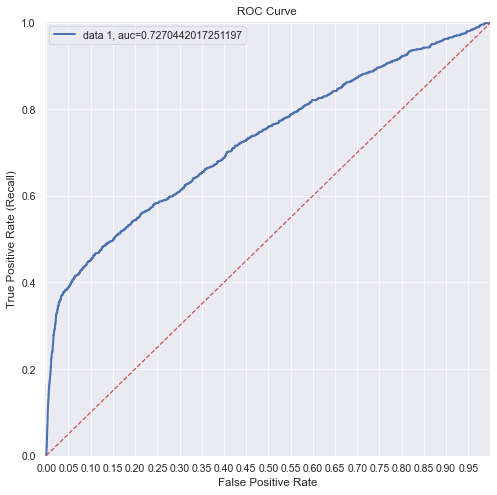

In [77]:
y_pred_proba = model_lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(auc)
plt.figure(figsize=(8,8))
plt.title('ROC Curve')
plt.plot(fpr, tpr, linewidth=2, label="data 1, auc="+str(auc))
plt.axis([-0.005, 1, 0, 1.005])
plt.xticks(np.arange(0,1, 0.05))
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc='best')


## Logistic Regression Prediction on act_delivery_days

C:\Users\eugen\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eugen\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


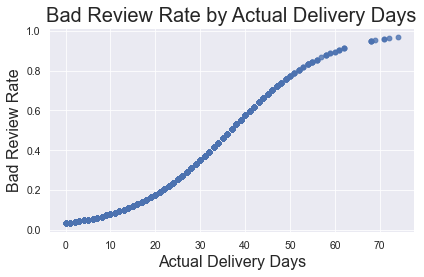

In [112]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(merged['act_delivery_days'], merged['bad_review'], test_size=0.20)

# create Logistic Regression classifier object
model_lr1 = LogisticRegression()

# execute the Logistic Regression on training data
X_test1 = X_test1.fillna(0)
X_train1 = X_train1.fillna(0)
y_train1 = y_train1.fillna(0)
y_test1 = y_test1.fillna(0)

model_lr1.fit(X_train1.values.reshape(-1, 1), y_train1.values.reshape(-1, 1))
model_lr1.score(X_test1.values.reshape(-1, 1), y_test1.values.reshape(-1, 1))

y_pred_sk = model_lr1.predict_proba(X_test1.values.reshape(-1, 1))[:,1]

sns.regplot(x=X_test1, y=y_pred_sk, logistic=True)
plt.title('Bad Review Rate by Actual Delivery Days', size=20)
plt.xlabel('Actual Delivery Days', size=16)
plt.ylabel('Bad Review Rate', size=16)
plt.tight_layout()
plt.show()

## feature importance

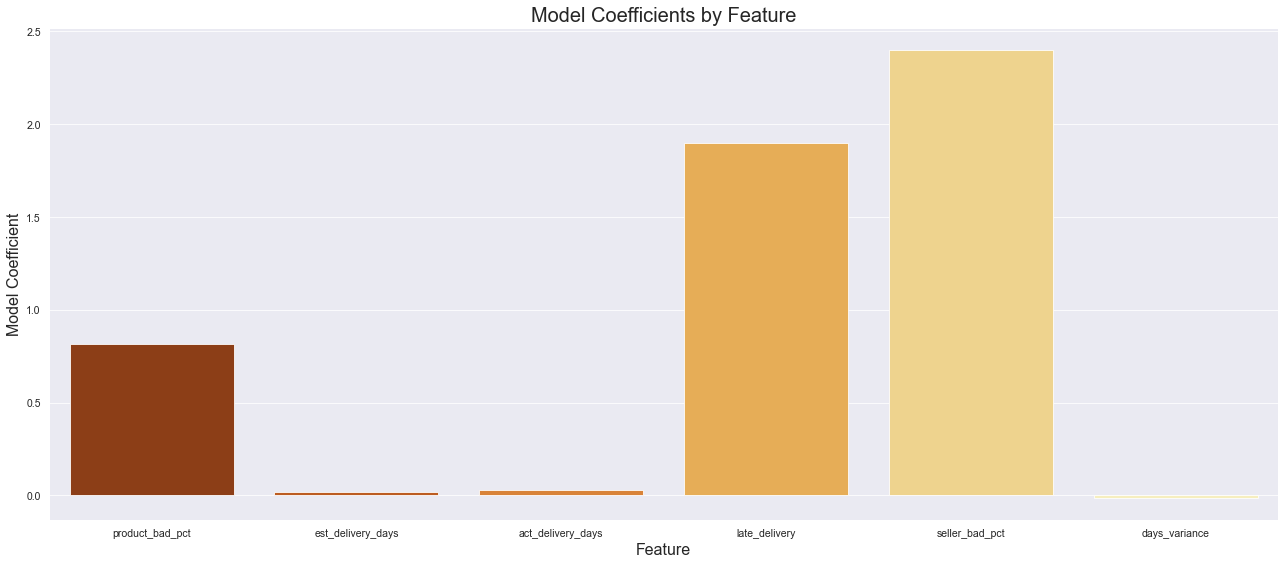

,feature,coef
0,product_bad_pct,0.82
1,est_delivery_days,0.02
2,act_delivery_days,0.03
3,late_delivery,1.90
4,seller_bad_pct,2.40
5,days_variance,-0.01


In [75]:
def feature_importance(model, X_df):
    """Extracts and plots relative feature importance based on classifier
    model coefficients.

    Parameters:
    - model (classifier): model estimator to use during grid search
    - X_df (pd.DataFrame): dataframe containing all X features/columns

    Returns:
    - coef_table (DataFrame): coefficient table by feature
    """    
    # create feature coefficient dataframe
    coef_table = pd.DataFrame(X_df.columns, columns=['feature'])
    coef_table.insert(1, 'coef', model.coef_.transpose())

    # plot feature coefficient on bar graph
    fig = plt.figure(figsize=(18, 8))
    sns.barplot(x='feature', y='coef', data=coef_table, palette='YlOrBr_r')
    plt.title('Model Coefficients by Feature', size=20)
    plt.xlabel('Feature', size=16)
    plt.ylabel('Model Coefficient', size=16)
    plt.tight_layout()
    plt.show()
    
    return coef_table

feature_importance(model_lr, X_test)